In [3]:
import pandas as pb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import gzip

from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize

from joblib import Parallel, delayed
import diffquantizer

In [189]:
def L1_R2(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        new_data.append(added_data[index-1][1] - added_data[index][0])
        # new_data.append(np.abs(added_data[index-1][1] - added_data[index][0]))
    return new_data

In [649]:
def Cross(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        L2_R1 = added_data[index][1] - added_data[index-1][0]
        R2_L1 = added_data[index][0] - added_data[index-1][1]
        new_data.append(np.abs(L2_R1 - R2_L1))
    return new_data

In [650]:
def Snake(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        L1_R1 = added_data[index-1][1] - added_data[index-1][0]
        R2_L1 = added_data[index][0] - added_data[index-1][1]
        new_data.append(L1_R1)
        new_data.append(R2_L1)
    return new_data

In [651]:
def SnakeRotate(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        R1_L1 = added_data[index-1][0] - added_data[index-1][1]
        L1_R2 = added_data[index-1][1] - added_data[index][0]
        new_data.append(R1_L1)
        new_data.append(L1_R2)
        # new_data.append(np.abs(R1_L1))
        # new_data.append(np.abs(L1_R2))
    return new_data

In [652]:
def FullSnake(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        R1_L1 = added_data[index-1][0] - added_data[index-1][1]
        L1_R2 = added_data[index-1][1] - added_data[index][0]
        R1_L2 = added_data[index-1][0] - added_data[index][1]
        new_data.append(R1_L1)
        new_data.append(np.abs(L1_R2 - R1_L2))
    return new_data

In [653]:
def SumSnake(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        R1_L1 = added_data[index-1][0] - added_data[index-1][1]
        L1_R2 = added_data[index-1][1] - added_data[index][0]
        R1_L2 = added_data[index-1][0] - added_data[index][1]
        new_data.append(np.abs(R1_L1 + (L1_R2 - R1_L2)))
    return new_data

In [654]:
def SumSnake2(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        R1_L1 = added_data[index-1][0] - added_data[index-1][1]
        L1_R2 = added_data[index-1][1] - added_data[index][0]
        R1_L2 = added_data[index-1][0] - added_data[index][1]
        new_data.append(np.abs(R1_L1 - (L1_R2 + R1_L2)))
    return new_data

In [655]:
def Ladder(added_data):
    new_data = []
    for index in range(1, len(added_data)):
        R1_L1 =  np.abs(added_data[index-1][0] - added_data[index-1][1])
        R1_R2 = np.abs(added_data[index-1][0] - added_data[index][0])
        L1_L2 = np.abs(added_data[index-1][1] - added_data[index][1])
        delta = np.abs(R1_R2 - L1_L2)
        new_data.append(R1_L1 - delta)
    return new_data

In [684]:
X = []
Y = []

for root, dirs, files in os.walk('Recording Data'):
    for file in files:
        if file.endswith(".txt") and file != 'Subject codes.txt':
            file_path = os.path.join(root, file)
            if int(root[-1]) <= 2:
                has_dyslexia = 1
            else:
                has_dyslexia = 0
                
            data = pd.read_csv(file_path, sep='\t', index_col=None, decimal=",")
            data['r_dist'] = (data['RX'].diff() ** 2 + data['RY'].diff() ** 2) ** 0.5
            data['l_dist'] = (data['LX'].diff() ** 2 + data['LY'].diff() ** 2) ** 0.5
            
            added_data = np.array([x for x in list(zip(data['r_dist'][1:], data['l_dist'][1:]))])
            
            # added_data = np.abs(added_data[:,0] - added_data[:,1]) #0.93...
            # added_data = np.diff(added_data)
            
            # added_data = L1_R2(added_data) #0,95
            # added_data = np.diff(added_data)

            # added_data = Cross(added_data) #0.939
            # added_data = np.diff(added_data)

            added_data = Snake(added_data) #0.956
            added_data = np.diff(added_data)

            # added_data = SnakeRotate(added_data) #0.956
            # added_data = np.diff(added_data)

            # added_data = FullSnake(added_data) #0.934
            # added_data = np.diff(added_data)

            # added_data = SumSnake(added_data) #0.95
            # added_data = np.diff(added_data)

            # added_data = SumSnake2(added_data) #0.945
            # added_data = np.diff(added_data)
            
            # added_data = Ladder(added_data) #0.939
            # added_data = np.diff(added_data)
            
            X.append(added_data)
            Y.append(has_dyslexia)

In [685]:
X = np.array(X,dtype = "object")
Y = np.array(Y)

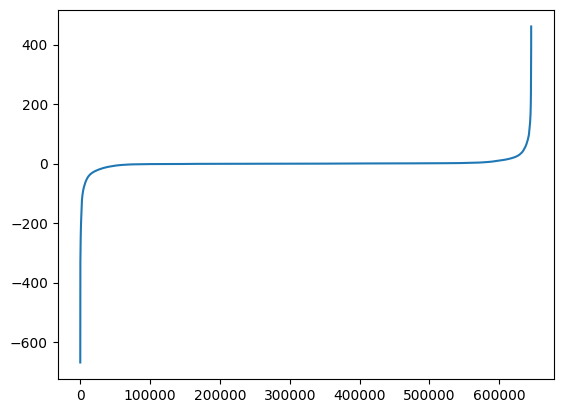

In [686]:
plt.plot(np.sort(np.concatenate(X)))

In [687]:
quantizer = diffquantizer.DiffQuantizer(600,use_diffs = False)

In [688]:
SPLITS = 5

In [689]:
kf = KFold(n_splits=SPLITS, shuffle = True, random_state = 160)

index_split = list(kf.split(X, Y))

In [690]:
for k in range(SPLITS):
    train_index, test_index = index_split[k]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    print(np.sum(Y_train)/len(Y_train), np.sum(Y_test)/len(Y_test))

0.5472972972972973 0.43243243243243246
0.527027027027027 0.5135135135135135
0.5337837837837838 0.4864864864864865
0.5 0.6216216216216216
0.5135135135135135 0.5675675675675675


In [691]:
def compresso(x):
    return(len(gzip.compress(bytes(x,"utf-8"))))

In [692]:
def predict_gzip(i, knn, X_train, X_test, CX_train, CX_test, Y_train):
    x1, Cx1 = X_test[i], CX_test[i]
    x1_append = np.zeros((X_train.shape), dtype = X_train.dtype)
    x1_append[:] = x1
    x1x2 = np.char.add(x1_append, X_train)
    
    Cx1x2 = np.vectorize(compresso)(x1x2)
    distances = (Cx1x2 - np.vectorize(min)(CX_train, Cx1))/np.vectorize(max)(CX_train, Cx1)
    
    sorted_idx = np.argsort(np.array(distances))
    
    top_k_class = Y_train[sorted_idx].astype(np.byte)
    #weights = 1
    
    top_k_class[top_k_class == 0] = -1
        
    return(top_k_class)

def w_distances_to_classes(k, weights, Y_test):
    predicted_classes = []
    for i in weights:
        pred = 0 if (np.sum(i[:k]) < 0) else 1
        predicted_classes.append(pred)
    acc = classification_report(Y_test,predicted_classes, output_dict = True)["macro avg"]["f1-score"]
    return(acc)

In [693]:
acc_curves = []

for fold in range(SPLITS):
    train_index, test_index = index_split[fold]

    X_train = X[train_index]
    X_test = X[test_index]
    
    X_trainflat = np.concatenate(X_train)
    
    breaks = quantizer.learn_breakpoints(X_trainflat)
    
    X_train_strings = []
    
    for i in X_train:
        stacked = i
        string = quantizer.perform_quantization(stacked,breaks)
        string = "".join([*(string)])
        X_train_strings.append(string)
    
    X_train_strings = np.array(X_train_strings)
    
    X_test_strings = []
    
    for i in X_test:
        stacked = i
        string = quantizer.perform_quantization(stacked,breaks)
        string = "".join([*(string)])
        X_test_strings.append(string)
    
    X_test_strings = np.array(X_test_strings)
    
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    
    CX_test = np.vectorize(compresso)(X_test_strings)
    CX_train = np.vectorize(compresso)(X_train_strings)

    weights = Parallel(n_jobs=12, prefer="processes", verbose = 3)(
        delayed(predict_gzip)(i, 0, X_train_strings, X_test_strings, CX_train, CX_test, Y_train) for i in range(len(X_test)))
    
    weights = np.vstack(weights)
    
    accs = Parallel(n_jobs=6, prefer="processes", verbose = 3)(
        delayed(w_distances_to_classes)(k, weights, Y_test) for k in range(1, len(X_train)-1))
    
    acc_curves.append(accs)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  27 out of  37 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  37 out of  37 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 146 out of 146 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  27 out of  37 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  37 out of  37 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 146 out of 146 | elapsed:    1.2s finished
[Paral

In [694]:
minser = min(len(i) for i in acc_curves)
fins = [np.array(i[:minser]) for i in acc_curves]
print(np.argmax(sum(fins)[::2])*2 + 1)

83


In [695]:
uniform_k_table = {}
k_list = [1,5,10,15,20,25,50,93,np.argmax(sum(fins)[::2])*2 + 1]

for k in k_list:
    acc_list = [i[k-1] for i in acc_curves]
    acc_list.append(np.average(acc_list))
    uniform_k_table["k="+str(k)] = acc_list
    
acc_list = [np.max(i[::2]) for i in acc_curves]
acc_list.append(np.average(acc_list))
uniform_k_table["best k"] = acc_list

In [696]:
table_uniform = pd.DataFrame(uniform_k_table).T
table_uniform.columns = ["Split " + str(i+1) for i in range(SPLITS)] + ["Avg."]

In [697]:
table_uniform

,Split 1,Split 2,Split 3,Split 4,Split 5,Avg.
k=1,0.945588,0.864865,0.918919,0.914943,0.917960,0.912455
k=5,0.945588,0.918681,0.918919,0.970843,0.972243,0.945255
k=10,0.945588,0.918681,0.891813,0.940705,0.972243,0.933806
k=15,0.917960,0.864469,0.891813,0.970843,0.972243,0.923466
k=20,0.889881,0.891176,0.918919,0.970843,0.944940,0.923152
k=25,0.945588,0.891176,0.891813,0.940705,0.944940,0.922845
k=50,0.917960,0.918681,0.891813,0.940705,0.972243,0.928280
k=93,0.945588,0.945588,0.918919,0.970843,0.972243,0.950636
k=83,0.945588,0.945588,0.945906,0.970843,0.972243,0.956034
best k,0.945588,0.945588,0.945906,0.970843,0.972243,0.956034
